In [5]:
import pandas as pd

In [6]:
df = pd.read_csv(r"/home/karthik/Desktop/drowsiness_detection_project/drowsiness_data/drowsiness_data.csv")

In [7]:
df.columns

Index(['Unnamed: 0', 'window_id', 'perclos', 'eye_blink_rate',
       'blink_duration', 'yawning_rate', 'steering_entropy',
       'steering_reversal_rate', 'std_lane_position', 'drowsiness_level'],
      dtype='object')

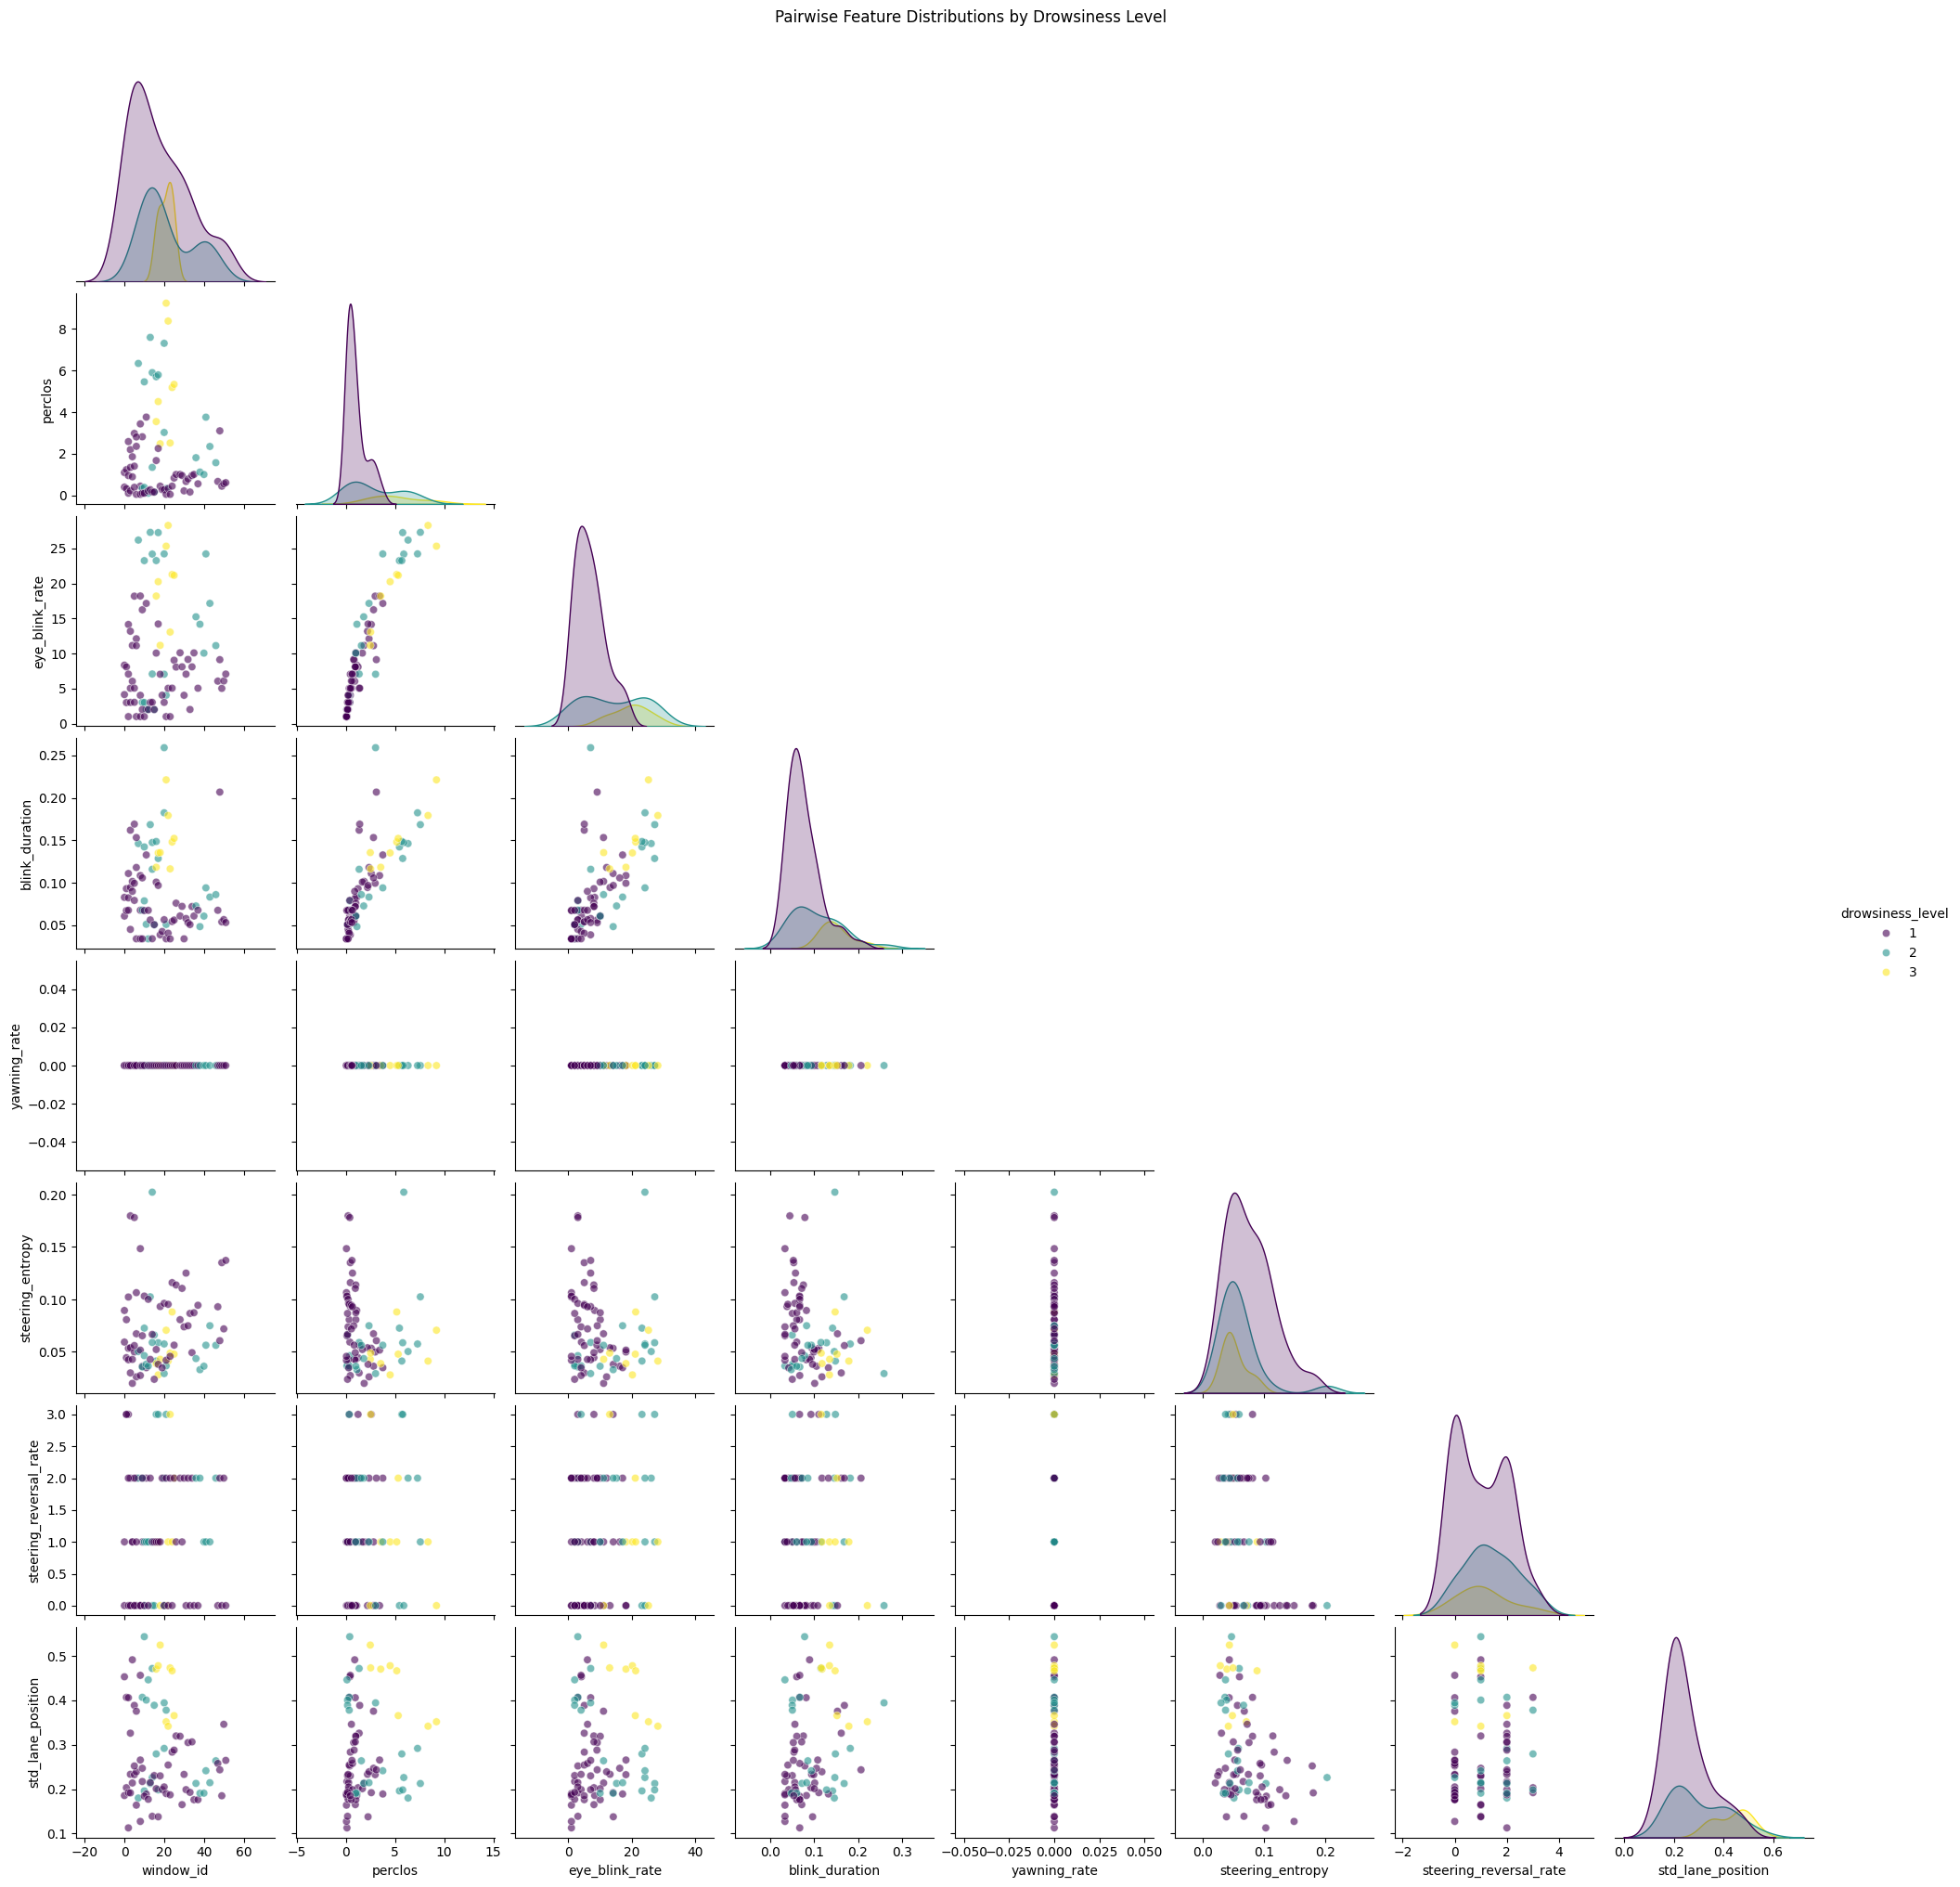

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = ['window_id', 'perclos', 'eye_blink_rate', 'blink_duration',
       'yawning_rate', 'steering_entropy', 'steering_reversal_rate',
       'std_lane_position']
target_col = 'drowsiness_level'


sns.pairplot(df, vars=feature_cols, hue=target_col, corner=True, plot_kws={'alpha':0.6}, palette="viridis")
plt.suptitle("Pairwise Feature Distributions by Drowsiness Level", y=1.02)
plt.show()


In [ ]:
# ===============================
# STEP 1 — Install and Import Libraries
# ===============================
!pip install mediapipe opencv-python pandas numpy

import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from IPython.display import clear_output

# ===============================
# STEP 2 — Initialize MediaPipe FaceMesh
# ===============================
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,         # for live video input
    max_num_faces=1,
    refine_landmarks=True,           # improves eye & lips precision
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# ===============================
# STEP 3 — Open Webcam Stream
# ===============================
cap = cv2.VideoCapture(0)  # 0 = default webcam

frame_data = []
frame_count = 0

print("🎥 Starting webcam — press 'q' to stop...")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("⚠️ No frame captured. Exiting.")
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame_rgb)

    landmarks_list = []
    frame_count += 1

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for lm in face_landmarks.landmark:
                # ✅ Filter using presence and visibility thresholds
                if (lm.presence > 0.5) and (lm.visibility > 0.5):
                    landmarks_list.append([lm.x, lm.y, lm.z])
                else:
                    landmarks_list.append([np.nan, np.nan, np.nan])

            # Draw landmarks for visualization
            mp.solutions.drawing_utils.draw_landmarks(
                frame,
                face_landmarks,
                mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles
                    .get_default_face_mesh_tesselation_style()
            )
    else:
        # No face detected → fill with NaNs
        landmarks_list = [[np.nan, np.nan, np.nan]] * 468

    frame_data.append(landmarks_list)

    # Show live video
    cv2.imshow('Filtered FaceMesh', frame)
    
    # Stop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("\n🛑 Stopped by user.")
        break

cap.release()
cv2.destroyAllWindows()
face_mesh.close()

print(f"✅ Captured {frame_count} frames.")

# ===============================
# STEP 4 — Convert to DataFrame
# ===============================
columns = []
for i in range(468):
    columns += [f"x_{i}", f"y_{i}", f"z_{i}"]

df = pd.DataFrame([np.array(f).flatten() for f in frame_data], columns=columns)

print("\n📊 DataFrame created:")
print(df.head())

# ===============================
# STEP 5 — Interpolate Missing Data
# ===============================
df = df.interpolate(limit_direction="both")

print("\n✅ After interpolation:")
print(df.isna().sum().sum(), "missing values remaining")

# ===============================
# STEP 6 — Save Cleaned Data
# ===============================
df.to_csv("webcam_filtered_landmarks.csv", index=False)
print("\n💾 Saved cleaned data to 'webcam_filtered_landmarks.csv'")


🎥 Starting webcam — press 'q' to stop...
✅ Captured 0 frames.

📊 DataFrame created:
Empty DataFrame
Columns: [x_0, y_0, z_0, x_1, y_1, z_1, x_2, y_2, z_2, x_3, y_3, z_3, x_4, y_4, z_4, x_5, y_5, z_5, x_6, y_6, z_6, x_7, y_7, z_7, x_8, y_8, z_8, x_9, y_9, z_9, x_10, y_10, z_10, x_11, y_11, z_11, x_12, y_12, z_12, x_13, y_13, z_13, x_14, y_14, z_14, x_15, y_15, z_15, x_16, y_16, z_16, x_17, y_17, z_17, x_18, y_18, z_18, x_19, y_19, z_19, x_20, y_20, z_20, x_21, y_21, z_21, x_22, y_22, z_22, x_23, y_23, z_23, x_24, y_24, z_24, x_25, y_25, z_25, x_26, y_26, z_26, x_27, y_27, z_27, x_28, y_28, z_28, x_29, y_29, z_29, x_30, y_30, z_30, x_31, y_31, z_31, x_32, y_32, z_32, x_33, ...]
Index: []

[0 rows x 1404 columns]

✅ After interpolation:
0 missing values remaining

💾 Saved cleaned data to 'webcam_filtered_landmarks.csv'


[ WARN:0@28.779] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@28.779] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
W0000 00:00:1762171499.540039  427029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762171499.549497  427030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [1]:
!pip install langchain langchain-openai faiss-cpu python-dotenv langchain-community

In [2]:
from langchain.memory import ConversationBufferWindowMemory
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationChain
import os

ModuleNotFoundError: No module named 'langchain.memory'